## BERT Classifier for Software & Hardware Jira Tickets
- PRTSIR = Hardware = 1
- ICT = Software = 0

In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

In [2]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_text as text

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

#hide warnings
import warnings
warnings.filterwarnings('ignore')


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/tensorflow_hub/__init__.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/tensorflow_hub/__init__.py:75: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dataiku/dss_data/code-envs/python/mypython/lib/python3.7/site-packages/transformers/generation_utils.py:27: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.

In [3]:
# Read recipe inputs
# Dataset pharmacy_dataset_reduced renamed to pharmacy_dataset_TEST by vkb6bn on 2023-03-08 17:42:52
data = dataiku.Dataset("PRTSIR_ICT_dataset_stacked")
data = data.get_dataframe()
len(data)

1365

In [4]:
data.head()

,key,text,label
0,PRTSIR-14176,auto generate ticket link exec webshiftlog?ebu...,1
1,PRTSIR-15676,e2e7 test observe delay offset 0.28nsec polari...,1
2,PRTSIR-1676,investigation az encoder problem prtsir-959 re...,1
3,PRTSIR-2184,run sb dv15 go error brake engage mapping ioni...,1
4,PRTSIR-5907,sbex focus sbs version --fail-- start end proj...,1


In [6]:
#drop any missing values
data = data.dropna()
#reset index
data=data.reset_index(drop=True) 
#shuffle data
data = shuffle(data)   
data.tail(3)

,key,text,label
1291,ICT-7566,"onkibana"",""onmonitoring notification channel a...",0
1112,ICT-9739,cyclen observation preparation please parse fa...,0
465,PRTSIR-12722,spectral checkout band sweep observation band ...,1


In [7]:
#define the number of unique classes under 'label'
num_classes=len(data.label.unique())
num_classes

2

In [8]:
#define y variable
y = tf.keras.utils.to_categorical(data["label"].values, num_classes=num_classes)
#y

#split data into test and train
x_train, x_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.3)
len(x_train), len(x_test), len(y_train), len(y_test)

(955, 410, 955, 410)

In [19]:
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [11]:
#load bert with tensorflow hub
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function to get word embeddings
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

#test function
#get_embeddings([
   # "This is a test para ver el futuro of the model."])

In [12]:
#resource: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
from keras import backend as K

#functions to find recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

#functions to find precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

#functions to find f1 score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [13]:
#define model
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

bert_model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
#define number of epochs
n_epochs = 10

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.TrueNegatives(),
      tf.keras.metrics.FalsePositives(),
      tf.keras.metrics.AUC(),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

#EarlyStopping callback to monitor validation loss
#if metric doesn't improve for at least 3 epochs (patience = 3)
    #training is interrupted and weights from epoch where the validation loss 
    #showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)


In [15]:
#compile model
bert_model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

In [16]:
#fit model
model_fit = bert_model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback], verbose=1)

Epoch 1/10


KeyboardInterrupt: 

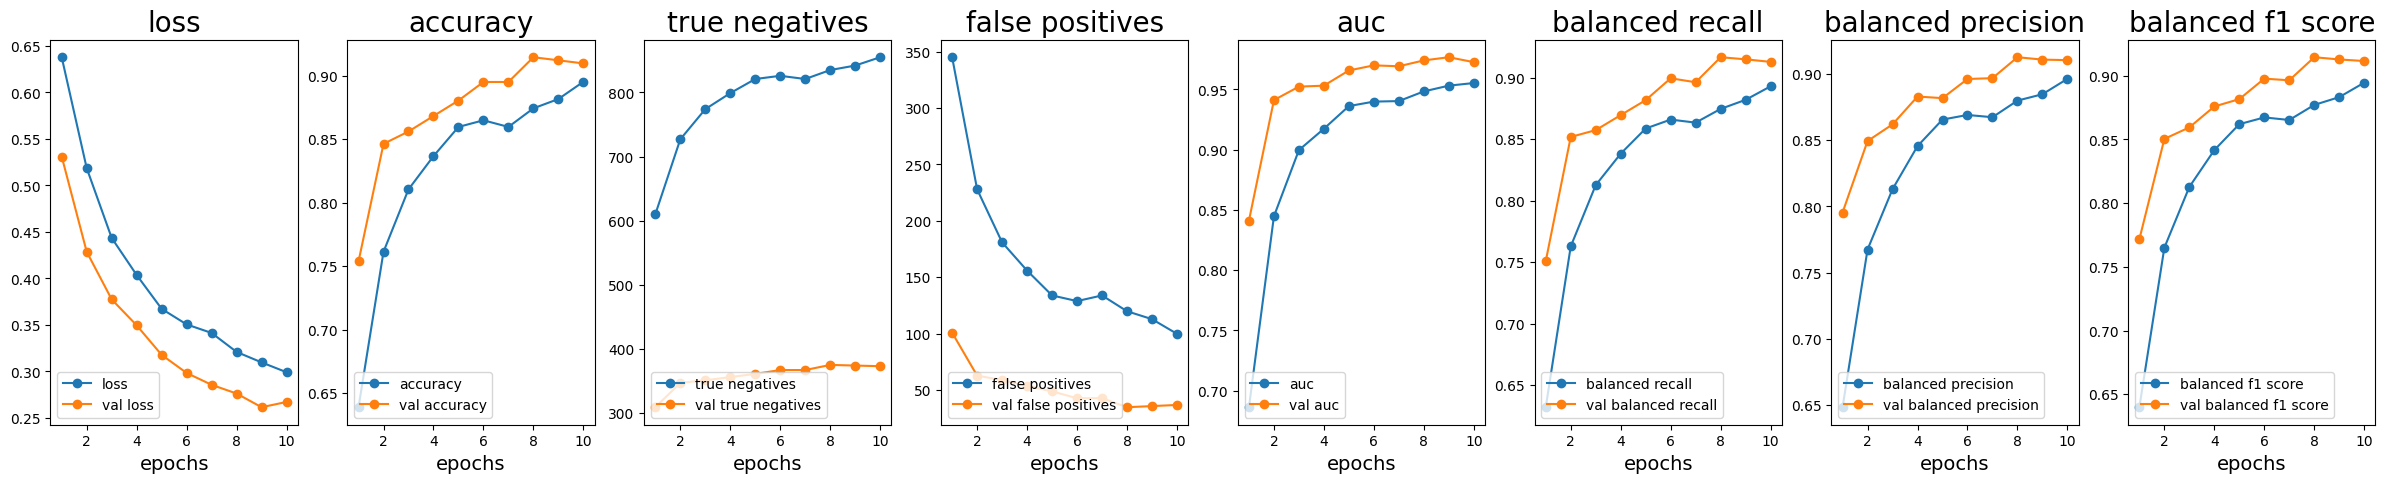

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [16]:
model_fit.history

{'loss': [0.6378862261772156,
  0.5186523199081421,
  0.4435788691043854,
  0.4037039577960968,
  0.3673222064971924,
  0.3505901098251343,
  0.34140023589134216,
  0.3210075795650482,
  0.30975955724716187,
  0.2991766035556793],
 'accuracy': [0.6387434601783752,
  0.7612565159797668,
  0.8104711771011353,
  0.8366492390632629,
  0.8596858382225037,
  0.8649214506149292,
  0.8596858382225037,
  0.8743455410003662,
  0.8816754221916199,
  0.8952879309654236],
 'true_negatives': [610.0,
  727.0,
  774.0,
  799.0,
  821.0,
  826.0,
  821.0,
  835.0,
  842.0,
  855.0],
 'false_positives': [345.0,
  228.0,
  181.0,
  156.0,
  134.0,
  129.0,
  134.0,
  120.0,
  113.0,
  100.0],
 'auc': [0.6862492561340332,
  0.8447339534759521,
  0.8996584415435791,
  0.9173756241798401,
  0.936191976070404,
  0.9399111270904541,
  0.9403377175331116,
  0.9483824968338013,
  0.953151524066925,
  0.9553252458572388],
 'balanced_recall': [0.6319847702980042,
  0.7627720236778259,
  0.8126202821731567,
  0.83

### Predictions

In [17]:
#ICT - Software Text
ICT_text = ["aca control operations software support inform operator time restart bl correlator acacorr observation runinng new instance ict-4841 not find channel average datum inspect log last month corroborate little ict-4841 relate bl restart common point bl aca gns network indeed bl machine reinitializing get image gns:/tftpboot/ aca node show log slow cdp transmission aca master example code 21t09:45:10.427 acc mastercontainer corr_master_comp shutdownsubsyspass1 method call /var log message cob cpn-05 syslogd restart remote reception cob cpn-14 syslogd restart remote reception cob cpn-03 syslogd restart remote reception cob cpn-13 syslogd restart remote reception cob cc syslogd restart remote reception cob cpn-07 syslogd restart remote reception cob cpn-15 syslogd restart remote reception cob cpn-04 syslogd restart remote reception cob cpn-01 syslogd restart remote reception cob cpn-02 syslogd restart remote reception cob cpn-16 syslogd restart remote reception cob cpn-06 syslogd restart remote reception cob cpn-09 syslogd restart remote reception cob cpn-12 syslogd restart remote reception cob cpn-08 syslogd restart remote reception cob cpn-11 syslogd restart remote reception cob cpn-10 syslogd restart remote reception 21t09:51:44.433 acacorr cdpmif cppcontainer acacorr cdpmif master not find channel average datum key[obs/0000002799/2/1 nid[9 file[acacdpmchanaverdataprocthread.cpp line[357 21t09:52:46.999 acacorr cdpmif cppcontainer acacorr cdpmif master not find channel average datum key[obs/0000002818/3/5 nid[5 file[acacdpmchanaverdataprocthread.cpp line[357 21t09:52:47.389 acacorr cdpc_data_mgr n07 cppcontainer acacorr cdpc_data_mgr node_07 cdp datum transmisson long elaps[4.138645(sp=0.000001/0.063965,ch=4.138644/4.138635 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:47.665 acacorr cdpc_data_mgr n32 cppcontainer acacorr cdpc_data_mgr node_32 cdp datum transmisson long elaps[4.418394(sp=0.000001/0.082536,ch=4.418393/4.418384 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:47.849 acacorr cdpc_data_mgr n13 cppcontainer acacorr cdpc_data_mgr node_13 cdp datum transmisson long elaps[4.599679(sp=0.000001/0.086688,ch=4.599678/4.599669 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:48.045 acacorr cdpc_data_mgr n30 cppcontainer acacorr cdpc_data_mgr node_30 cdp datum transmisson long elaps[4.806524(sp=0.000001/0.083923,ch=4.806523/4.806515 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:49.003 acacorr cdpc_data_mgr n22 cppcontainer acacorr cdpc_data_mgr node_22 cdp datum transmisson long elaps[5.766346(sp=0.000001/0.060834,ch=5.766345/5.766336 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:49.003 acacorr cdpc_data_mgr n20 cppcontainer acacorr cdpc_data_mgr node_20 cdp datum transmisson long elaps[5.764070(sp=0.000001/0.039338,ch=5.764069/5.764060 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:49.003 acacorr cdpc_data_mgr n21 cppcontainer acacorr cdpc_data_mgr node_21 cdp datum transmisson long elaps[5.759761(sp=0.000001/0.086281,ch=5.759760/5.759751 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:49.027 acacorr cdpc_data_mgr n06 cppcontainer acacorr cdpc_data_mgr node_06 cdp datum transmisson long elaps[5.771451(sp=0.000001/0.061036,ch=5.771450/5.771441 file[acacdpcdatapublisherthread.cpp line[258 21t09:52:49.707 acacorr cdpc_data_mgr n29 cppcontainer acacorr cdpc_data_mgr node_29 cdp datum transmisson long elaps[5.457301(sp=0.000001/0.058710,ch=5.457300/5.457292 file[acacdpcdatapublisherthread.cpp line[258 code assign ticket initially softops order deeply understand relation apparently separate subsytems bl corr restart time aca cdp datum transmisson long"]
PRTSIR_text = ["arp nuclear disks ma resolution version --fail-- start end project code pi nscoville schedblock arp220_a_03_te execblock uid://a002 xac2df7 x18e8 sb uid uid://a001 x2d6 x1c qa0 status band alma_rb_03 alma build 201508-cycle3-on ict-5436-b-2015 array array010 array corr m]/64-antenna sbex fail start scan follow error noformat summary problem execute scan sequence problem complete subscan correlator resource conflict details error trace code type file util.java host gas01 line number process control acc javacontainer routine tocompletion short description unrecoverable error occur source object control array010 thread thread-11235 additional data usererrormessage value problem execute scan sequence javaex.class value alma controlexceptions.wrappers acsjfatalex error trace code type file subscanseqcbimpl.java host gas01 line number process control acc javacontainer routine waitforsubscanend short description unrecoverable error occur source object control array010 thread thread-11235 additional data javaex.class value alma controlexceptions.wrappers acsjfatalex usererrormessage value problem complete subscan javaex.msg value error trace code type file arraythread.cpp host cob cdpm b line number process corr cdpmaster cppcontainer routine abort short description correlator resource conflict source object control array010 thread cdp_master_thread_0 additional data cause value datum cluster master node time javaex.msg value javaex.class value alma.acs.exceptions defaultacsjexception noformat jlog noformat 27t16:05:31.861 critical control_system consumer process_event took long handle execblockendedevent event second 27t16:05:25.650 error scheduling array010 internal exception scheduling type=80100 code=1 27t16:05:25.649 error scheduling array010 java.lang nullpointerexception type=9 code=-1 27t16:05:25.468 critical none error script execution acserr errortrace(file='/alma acs-2014.6 acssw bin linenum=138 routine='<module host='gas01 process='23380 thread='mainthread timestamp=136652547254381210l sourceobject= errortype=10100l errorcode=5l severity error shortdescription='general scriptexecutor runtime error data= previouserror=[acserr errortrace(file='util.java linenum=398 routine='tocompletion host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547141550000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='usererrormessage value='problem execute scan sequence acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex previouserror=[acserr errortrace(file='subscanseqcbimpl.java linenum=315 routine='waitforsubscanend host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547132260000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex acserr namevalue(name='usererrormessage value='problem complete subscan acserr namevalue(name='javaex.msg value= previouserror=[acserr errortrace(file='arraythread.cpp linenum=5210 routine='abort host='cob cdpm b process='corr cdpmaster cppcontainer thread='cdp_master_thread_0 timestamp=136652544231580000l sourceobject='control array010 errortype=20000l errorcode=8l severity error shortdescription='correlator resource conflict data=[acserr namevalue(name='cause value='data cluster master node time acserr namevalue(name='javaex.msg value= acserr namevalue(name='javaex.class value='alma.acs.exceptions defaultacsjexception previouserror= 27t16:05:25.441 critical none setexecerror error script execution acserr errortrace(file='/alma acs-2014.6 acssw bin linenum=138 routine='<module host='gas01 process='23380 thread='mainthread timestamp=136652547254381210l sourceobject= errortype=10100l errorcode=5l severity error shortdescription='general scriptexecutor runtime error data= previouserror=[acserr errortrace(file='util.java linenum=398 routine='tocompletion host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547141550000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='usererrormessage value='problem execute scan sequence acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex previouserror=[acserr errortrace(file='subscanseqcbimpl.java linenum=315 routine='waitforsubscanend host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547132260000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex acserr namevalue(name='usererrormessage value='problem complete subscan acserr namevalue(name='javaex.msg value= previouserror=[acserr errortrace(file='arraythread.cpp linenum=5210 routine='abort host='cob cdpm b process='corr cdpmaster cppcontainer thread='cdp_master_thread_0 timestamp=136652544231580000l sourceobject='control array010 errortype=20000l errorcode=8l severity error shortdescription='correlator resource conflict data=[acserr namevalue(name='cause value='data cluster master node time acserr namevalue(name='javaex.msg value= acserr namevalue(name='javaex.class value='alma.acs.exceptions defaultacsjexception previouserror= 27t16:05:21.868 warning control dv17 floog counted incorrect numb 125mhz clock cycle lead phase jump please check floog necessary switch invert clock set_clock_inversion command reset latch reset_fts_status command 27t16:05:19.104 error corr ccc cppcontainer gl array associate exist configuration type=20000 code=12 27t16:05:19.103 warning control array010 correlator not destroy array prevent subsequent use correlator 27t16:05:19.092 error corr ccc cppcontainer gl correlator resource conflict type=20000 code=8 27t16:05:19.091 error corr cdpmaster cppcontainer gl method fail execution method node clearallids corr cdp_node n09 exception throw clustercommander.cpp:297 unknown exception 27t16:05:19.090 error corr cdpmaster cppcontainer gl method fail execution method node clearallids corr cdp_node n01 exception throw clustercommander.cpp:297 unknown exception 27t16:05:15.982 warning control array010 correlator not clear configuration calibration prevent subsequent use correlator 27t16:05:15.962 error corr cdpmaster cppcontainer gl method fail execution method node clearallids corr cdp_node n09 exception throw clustercommander.cpp:297 unknown exception 27t16:05:15.961 error corr cdpmaster cppcontainer gl method fail execution method node clearallids corr cdp_node n01 exception throw clustercommander.cpp:297 unknown exception 27t16:05:14.260 info control array010 interferometry observe mode shut 27t16:05:14.208 error ssr array010-bl standardinterferometry array010-bl standardinterferometry exception catch controlexceptions fatalex(errortrace acserr errortrace(file='util.java linenum=398 routine='tocompletion host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547141550000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='usererrormessage value='problem execute scan sequence acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex previouserror=[acserr errortrace(file='subscanseqcbimpl.java linenum=315 routine='waitforsubscanend host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547132260000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex acserr namevalue(name='usererrormessage value='problem complete subscan acserr namevalue(name='javaex.msg value= previouserror=[acserr errortrace(file='arraythread.cpp linenum=5210 routine='abort host='cob cdpm b process='corr cdpmaster cppcontainer thread='cdp_master_thread_0 timestamp=136652544231580000l sourceobject='control array010 errortype=20000l errorcode=8l severity error shortdescription='correlator resource conflict data=[acserr namevalue(name='cause value='data cluster master node time acserr namevalue(name='javaex.msg value= acserr namevalue(name='javaex.class value='alma.acs.exceptions defaultacsjexception previouserror= 27t16:05:14.207 error ssr array010-bl standardinterferometry array010-bl scanlist controlexceptions fatalex(errortrace acserr errortrace(file='util.java linenum=398 routine='tocompletion host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547141550000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='usererrormessage value='problem execute scan sequence acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex previouserror=[acserr errortrace(file='subscanseqcbimpl.java linenum=315 routine='waitforsubscanend host='gas01 process='control acc javacontainer thread='thread-11235 timestamp=136652547132260000l sourceobject='control array010 errortype=10000l errorcode=16l severity error shortdescription='an unrecoverable error occur data=[acserr namevalue(name='javaex.class value='alma controlexceptions.wrappers acsjfatalex acserr namevalue(name='usererrormessage value='problem complete subscan acserr namevalue(name='javaex.msg value= previouserror=[acserr errortrace(file='arraythread.cpp linenum=5210 routine='abort host='cob cdpm b process='corr cdpmaster cppcontainer thread='cdp_master_thread_0 timestamp=136652544231580000l sourceobject='control array010 errortype=20000l errorcode=8l severity error shortdescription='correlator resource conflict data=[acserr namevalue(name='cause value='data cluster master node time acserr namevalue(name='javaex.msg value= acserr namevalue(name='javaex.class value='alma.acs.exceptions defaultacsjexception previouserror= 27t16:05:14.207 error ssr array010-bl standardinterferometry array010-bl scanlist pretty trace errortrace timestamp tue oct file util.java line=398 routine tocompletion host gas01 process control acc javacontainer thread thread-11235 type=10000 code=16 shortdescrip unrecoverable error occur severity error data usererrormessage value problem execute scan sequence javaex.class value alma controlexceptions.wrappers acsjfatalex errortrace timestamp tue oct file subscanseqcbimpl.java line=315 routine waitforsubscanend host gas01 process control acc javacontainer thread thread-11235 type=10000 code=16 shortdescrip unrecoverable error occur severity error data javaex.class value alma controlexceptions.wrappers acsjfatalex usererrormessage value problem complete subscan javaex.msg value= errortrace timestamp tue oct file arraythread.cpp line=5210 routine abort host cob cdpm b process corr cdpmaster cppcontainer thread cdp_master_thread_0 type=20000 code=8 shortdescrip correlator resource conflict severity error data cause value datum cluster master node time javaex.msg value= javaex.class value alma.acs.exceptions defaultacsjexception 27t16:05:14.206 error ssr array010-bl standardinterferometry array010-bl scanlist exception throw obsmode.doscansequence consider fatal 27t16:05:14.155 error control array010 unrecoverable error occur type=10000 code=16 27t16:05:14.122 error telcal acc cppcontainer2-static exception severity 27t16:05:14.121 error telcal acc cppcontainer2-static exception line 27t16:05:14.120 error telcal acc cppcontainer2-static exception file scanprocessedeventconsumer.cpp 27t16:05:14.120 error telcal acc cppcontainer2-static exception routine void scanprocessedeventconsumer::processscanprocessedevent 27t16:05:14.119 error telcal acc cppcontainer2-static exception type 27t16:05:14.119 error telcal acc cppcontainer2-static exception code 27t16:05:14.118 error telcal acc cppcontainer2-static telcal_datamanager_bdnt_1 exception catch receivingdatamanagerbdnt::handlescanprocessedevent 27t16:05:14.118 error telcal acc cppcontainer2-static exception shortdescription metadata not available 27t16:05:14.111 emergency control array010 dc002 getfinalmetadataql no row table find java.lang nullpointerexception 27t16:05:14.075 warning telcal acc cppcontainer2-static telcal_totalpower_receiver_bdnt_1 ignore scanprocessed event scannum=3 not find calibration 27t16:05:14.068 warning control array010 dc002 executed subscans control report successfully complete datum bad miss 27t16:05:14.068 error control array010 unrecoverable error occur type=10000 code=16 27t16:05:13.229 error control array010 unrecoverable error occur type=10000 code=16 27t16:05:13.226 error control array010 unrecoverable error occur type=10000 code=16 27t16:05:13.226 error control array010 unrecoverable error occur type=10000 code=16 27t16:05:13.226 error control array010 unrecoverable error occur type=10000 code=16 noformat corr subsystem go error cdpnode01 container stop coredump noformat -rw------- almaproc almaproc oct core.cob cpn-01.macicontainer.4349 -rw------- almaproc almaproc oct core.cob cpn-09.macicontainer.4353 noformat nukediskless -c perform continue observation aos bl node container crash unrecoverable error occur aos"]

In [18]:
#predict class function
def predict_class(test_text):
  '''predict class of input text
  Args:
    - comments (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in bert_model.predict(test_text)]

In [19]:
predict_class(ICT_text)

1/1 [==============================] - 1s 852ms/step


[0]

In [20]:
predict_class(PRTSIR_text)

1/1 [==============================] - 0s 152ms/step


[1]